In [1]:
import shutup
shutup.please()

# import gym
# import src.environments.continuous.stock_trading  

import numpy as np
import pandas as pd 

from tqdm.notebook import trange, tqdm

### Train the agent
* Run it until he has a running average above the success_threshold
* Use a large number of episodes for the running average ( 1000+ ) so if even it falls into a privileged sample, it wont be prone to error

In [2]:
from src.agents.ppo import PpoAgent
from src.environments.trading_environment import environment

In [3]:
def _environment(describe=True):
    env = environment(    
    describe=describe,
#     lookback=21,
#     window_size=126,
#     continuous=False,
#     start_date=False,
#     end_date=False,
#     train_percentage=0.8,
#     use_technical_indicators=[
#         "macd",
#         "boll_ub",
#         "boll_lb",
#         "rsi_30",
#         "cci_30",
#         "dx_30",
#         "close_30_sma",
#         "close_60_sma",
#     ],
#     use_sentiment_analysis=True,
#     use_cboe_vix=True,
#     use_trends=True,
#     use_fear_and_greed=True,
#     use_market_volatility="DOW_30",
    ticker="MSFT",
#     initial_investment=False,
#     inertness_punishment_method=None,
#     inertness_punishment_value=0,
#     maximum_stocks_held=10,
#     fees=FEES,
#     seed=False,
#     mode="train",
    )
    
    env.success_threshold = 0.4
    #env.success_threshold = poc_threshold
    
    return env


In [4]:
agent=PpoAgent(
        _environment,
        actor_learning_rate=0.000025,
        critic_learning_rate=0.000025,
        policy="CNN",
        epochs=10,
        n_workers=8)



        | ---------------------------------
        | MsftStockTradingEnvironment-v0
        | 
        | Author: Pihh - pihh.rocks@gmail.com
        | Description: Configurable stock trading environment for my trading bot
        | Action space: Discrete with high state-space
        | Environment beated threshold: 0.0877976262128356
        | -----------------------------------------
        | Configuration:
        |
        | Dataset and market related:
        |   * Ticker: MSFT
        |   * Lookback: 21
        |   * Episode length: 126
        |   * Technical indicators: ['boll_lb', 'boll_ub', 'cci_30', 'close_30_sma', 'close_60_sma', 'dx_30', 'macd', 'rsi_30']
        |   * Uses trend analysis: True
        |   * News sentiment analysis: True
        |   * Uses CBOE VIX: True
        |   * Uses fear and greed:  True
        |   * Uses market volatility: DOW_30
        |   
        |
        | Portfolio, broker and rewards related:
        |   * Broker fees: ✫(BUY=0.001, SELL=

* Booting worker 0
* Booting worker 1
* Booting worker 2
* Booting worker 3
* Booting worker 4
* Booting worker 5
* Booting worker 6
* Booting worker 7
Episode * 100 * Worker #3 * Moving Avg Reward is ==> 0.27341 * Last Reward was ==> 0.25885 
Episode * 200 * Worker #7 * Moving Avg Reward is ==> 0.27314 * Last Reward was ==> 0.28288 

* Will replay
* Worker 0 finnished learning phase
* Worker 1 finnished learning phase
* Worker 2 finnished learning phase
* Worker 3 finnished learning phase
* Worker 4 finnished learning phase
* Worker 5 finnished learning phase
* Worker 6 finnished learning phase
* Worker 7 finnished learning phase
* Will resume

Episode * 300 * Worker #3 * Moving Avg Reward is ==> 0.27458 * Last Reward was ==> 0.29816 
Episode * 400 * Worker #7 * Moving Avg Reward is ==> 0.27614 * Last Reward was ==> 0.30309 
Episode * 500 * Worker #3 * Moving Avg Reward is ==> 0.27718 * Last Reward was ==> 0.28603 

* Will replay
* Worker 0 finnished learning phase
* Worker 1 finnishe

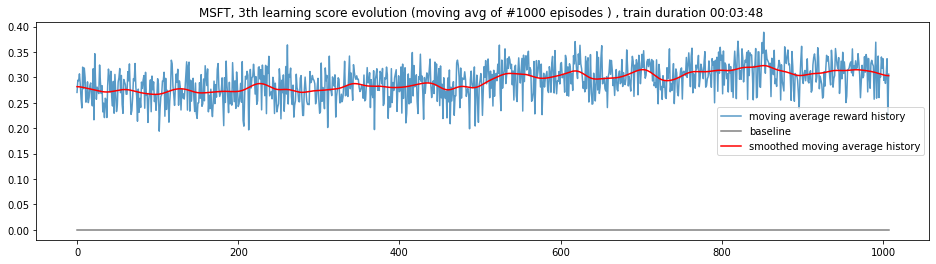

In [5]:
agent.load()
    
agent.learn(
        timesteps=-1, 
        log_every=100,
        success_threshold_lookback=1000,
        success_strict=True,
    )

In [6]:
agent.training_duration

'00:03:48'

### Test the results
* Runs a set of episodes with unseen data
* Stores the results in a csv file for later consulting

In [7]:
success = 0
n_tests = 10000

scores = []
targets = []
portfolio_target_ratios = []
initial_investments = []

for i in trange(n_tests):
    state = agent.env.reset(visualize=False,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    
    targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
    initial_investments.append(agent.env.initial_investment)

    while not done:
        state = agent.reshape_state(state)
        agent.env.render()
        #state = np.expand_dims(state, axis=0)
        action, action_onehot, prediction = agent.choose_action(state)
        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, info = agent.env.step(action)
        #print(action, reward, agent.env.portfolio_value)
        # Memorize (state, action, reward) for training
        #self.buffer.remember(np.expand_dims(state, axis=0), action_onehot, reward)
        # Update current state
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1

        step+=1
        state = next_state
        score += reward
    
    # Track scores and ratios
    scores.append(score)
    portfolio_target_ratios.append(info["portfolio_value"]/info["episode_target"] -1)
    
    
test_results_dataframe_summary = pd.DataFrame([[
    n_tests,
    str(round(np.mean(scores)*100,3))+'%',
    str(round(np.mean(targets)*100,3))+'%',
    str(round(np.mean(portfolio_target_ratios)*100,3))+'%',
    str(round(min(scores)*100,3))+'%',
    str(round(max(scores)*100,3))+'%',
    str(round((success/n_tests)*100,3)) +'%'
]],
    columns=[
        '# Blind tests',
        '% Average portfolio return', 
        '% Desired portfolio return', 
        'Portfolio/Target rate',
        '% Historical minimum return',
        '% Historical maximum return', 
        '% Episodes concluded with positive outcome'
    ]
)


agent.results_writer.store_test_results(agent,test_results_dataframe_summary,name="test_run_summary")


test_results_dataframe_summary.T

  0%|          | 0/10000 [00:00<?, ?it/s]

,0
# Blind tests,10000
% Average portfolio return,9.817%
% Desired portfolio return,2.16%
Portfolio/Target rate,7.493%
% Historical minimum return,1.853%
% Historical maximum return,14.024%
% Episodes concluded with positive outcome,100.0%


In [8]:
from src.agents.random import RandomAgent

random_agent = RandomAgent(environment(), n_tests)
random_agent_results = random_agent.run()

print(np.mean(random_agent_results))
random_agent_results


        | ---------------------------------
        | AaplStockTradingEnvironment-v0
        | 
        | Author: Pihh - pihh.rocks@gmail.com
        | Description: Configurable stock trading environment for my trading bot
        | Action space: Discrete with high state-space
        | Environment beated threshold: 0.12278957139454123
        | -----------------------------------------
        | Configuration:
        |
        | Dataset and market related:
        |   * Ticker: AAPL
        |   * Lookback: 21
        |   * Episode length: 126
        |   * Technical indicators: ['boll_lb', 'boll_ub', 'cci_30', 'close_30_sma', 'close_60_sma', 'dx_30', 'macd', 'rsi_30']
        |   * Uses trend analysis: True
        |   * News sentiment analysis: True
        |   * Uses CBOE VIX: True
        |   * Uses fear and greed:  True
        |   * Uses market volatility: DOW_30
        |   
        |
        | Portfolio, broker and rewards related:
        |   * Broker fees: ✫(BUY=0.001, SELL

[0.048757641882206,
 0.014600348724232267,
 0.015089708737486782,
 0.03832639234624248,
 0.05140825497209756,
 0.004791777805463921,
 0.00723660102364571,
 0.013604915634662255,
 0.02601464118808362,
 -0.01805211616053965,
 0.01376920869560911,
 -0.025980684867424737,
 0.009990161742430557,
 -0.029350839773565025,
 0.020653534590757052,
 0.023606706337920925,
 0.06532044700557543,
 0.019803319825531015,
 -0.009671388848032285,
 0.009737841457786804,
 0.0012134423211556259,
 0.0075619083324710646,
 0.013508410891218472,
 -0.02806332574341389,
 0.029005739014479694,
 0.014502379027699465,
 0.10769729652161934,
 0.03151224463982095,
 0.028601889526745743,
 -0.008953489163049902,
 -0.01278701606624047,
 0.015132624977381662,
 0.09266040826154544,
 -0.012852984220101732,
 0.026499983270298823,
 0.053057173587031284,
 0.007525847633257626,
 0.048772505990005315,
 0.04507804813291975,
 0.005662271463942901,
 0.039654459164748176,
 0.048311639798081216,
 0.012194883421849038,
 0.10597483293602

In [13]:
np.mean(random_agent_results)

0.0181031168230893

### Visual test
* Runs a set of episodes with unseen data
* See the evolution in real time


In [9]:
# success = 0
# n_tests = 2

# scores = []
# targets = []


# for i in trange(n_tests):
#     state = agent.env.reset(visualize=True,mode="test")
#     step = 0
#     score = 0
#     reward = 0
#     done = False
#     targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
#     initial_portfolio = agent.env.portfolio_value

#     while not done:
#         agent.env.render()
        
#         # Shape the state
#         state = agent.reshape_state(state)
#         # Select a action
#         action, action_onehot, prediction = agent.choose_action(state)
        
#         # Retrieve new state, reward, and whether the state is terminal
#         next_state, reward, done, _ = agent.env.step(action)
        
#         # End of episode, track scores here
#         if done :
#             if agent.env.portfolio_value > agent.env.initial_investment:
#                 success +=1

#         step+=1
#         state = next_state
#         score += reward
    
#     scores.append(score)

# agent.env.close()

### Transactions profit
* Track how much the agent gained by doing purchases and sales
* Doesn't track the portfolio value 
* Already has the fees discounted

In [10]:
success = 0
n_tests = 10000

test_transactions_results_data = []
test_transactions_results_columns = [
    'dataset id',
    'episode start date', 
    'episode end date',
    'episode working days',
    'total transactions',
    'profitable transactions',
    'non profitable transactions',
    'total transaction profit %',
    'initial portfolio value',
    'ending portfolio value',
    "dataframe hash",
    "agent hash"
]

print('NOTE: This test only tracks the transactions profit. ')

for i in trange(n_tests):
    trading_history = []
    state = agent.env.reset(visualize=False,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    #targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
    #initial_portfolio = agent.env.portfolio_value
    
    j = 0
    num_stocks = 0
    while not done:
        agent.env.render()
        
        # Select desired action
        state = agent.reshape_state(state)
        action, action_onehot, prediction = agent.choose_action(state)
        current_price = agent.env.df.iloc[agent.env.current_step -1]['close']
        
        if action == agent.env.actions.BUY:
            discounted_price = current_price * (1+agent.env.fees.BUY) 
            if agent.env.stock_held < agent.env.maximum_stocks_held and agent.env.cash_in_hand >= discounted_price:
                num_stocks +=1
                trading_history.append(['buy', discounted_price])
        elif action == agent.env.actions.SELL:
            if agent.env.stock_held > 0:
                discounted_price = current_price * (1-agent.env.fees.SELL) 
                trading_history.append(['sell', discounted_price])
                num_stocks =0
                
        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, _ = agent.env.step(action)

        # Update current state
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1
                
            profits = []
            purchases = []
            for e in trading_history:
                if e[0] == 'buy':
                    purchases.append(e[1])
                else:
                    profit= (e[1]* len(purchases) - sum(purchases)) / sum(purchases)
                    profits.append(profit)
                    purchases.clear() 
                    
            _profits = np.array(profits)    
            
            test_transactions_results_data.append([
                agent.env.dataset_idx,
                agent.env.df.iloc[agent.env.lookback].name,
                agent.env.df.iloc[-1].name,
                agent.env.window_size,
                len(profits),
                len(_profits[_profits > 0]),
                len(_profits[_profits <= 0]),
                sum(profits)*100,
                agent.env.initial_investment,
                agent.env.portfolio_value,
                agent.env.df_name,
                agent.hash
            ])


        step+=1
        state = next_state
        score += reward
    

agent.env.close()


test_transactions_results_dataframe = pd.DataFrame(test_transactions_results_data,columns=test_transactions_results_columns)

agent.results_writer.store_test_results(agent,test_transactions_results_dataframe,name="test_transactions")

# Display dataframe
test_transactions_results_dataframe

NOTE: This test only tracks the transactions profit. 


  0%|          | 0/10000 [00:00<?, ?it/s]

,dataset id,episode start date,episode end date,episode working days,total transactions,profitable transactions,non profitable transactions,total transaction profit %,initial portfolio value,ending portfolio value,dataframe hash,agent hash
0,284,2019-04-17,2019-10-16,126,2,2,0,8.918447,1216.500015,1353.569583,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
1,287,2019-04-23,2019-10-21,126,3,2,1,5.622589,1240.000000,1302.015002,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
2,283,2019-04-16,2019-10-15,126,2,2,0,8.688198,1215.800018,1332.145170,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
3,289,2019-04-25,2019-10-23,126,3,1,2,2.995465,1258.499985,1281.814833,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
4,304,2019-05-16,2019-11-13,126,3,2,1,8.478751,1267.099991,1390.352106,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,286,2019-04-22,2019-10-18,126,3,2,1,5.871217,1235.199966,1320.557274,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
9996,309,2019-05-23,2019-11-20,126,3,2,1,8.859925,1282.400055,1441.171140,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
9997,308,2019-05-22,2019-11-19,126,3,2,1,8.924383,1275.299988,1434.686943,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74
9998,292,2019-04-30,2019-10-28,126,2,1,1,5.787790,1301.799927,1407.155019,466050e5494591d46c7d5ae81f468b29,a64759445873b372b2b7a5a83386de74


In [11]:
failed_episodes_df = test_transactions_results_dataframe[test_transactions_results_dataframe['total transaction profit %'] <= 0]
failed_episodes_idx = failed_episodes_df['dataset id'].unique()
failed_episodes_idx.sort()

In [12]:
import matplotlib.pyplot as plt 

for idx in failed_episodes_idx:
    plt.figure(figsize=(16,4))
    plt.plot(agent.env.df['close'])
    plt.title('#'+str(idx)+' - ' + str(len(failed_episodes_df[failed_episodes_df['dataset id'] == idx])) +'/' + str(len(transaction_results_df[transaction_results_df['dataset id'] == idx])))